# Computational Neuroscience

PSYC B265, Fall 2025


## Setup colab notebook

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

For today's lab, we will need to load a matlab file. For this, we will use `scipy.io`. from `scipy.io`, import `loadmat`.

In [2]:
from scipy.io import loadmat

For PCA, we will use `scikit-learn` (https://scikit-learn.org/) which provides machine learning tools. The package we used for decoding lab `nilearn` is built on `scikit-learn`.

In [3]:
from sklearn.decomposition import PCA

## Basics: PCA

PCA is a dimensionality-reduction technique that finds the axes along which the data vary most. Conceptually, it identifies weights of the input dimensions such that the resulting weighted average (projection) varies as much as possible.

### 2D

We will first generate 2D data where two dimensions are correlated find an axis along which we can get the highest variance. 

In [4]:
# helper function to rotate a matrix
def phi(theta):
  """
  convert angle to radians and return a rotation matrix
  """
  theta = np.radians(theta)
  return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

In [5]:
m = 100  # number of trials

# sample m data from the distribution
np.random.seed(123) # for reproducibility

# data points where two neurons are correlated
X = (phi(60)@ (np.array([[1.2, 0], [0, 0.2]]) @ np.random.randn(m, 2).T)).T

#### TODO: 

Inspect the data in the matrix `X` by plotting the matrix as an image using `plt.matshow`. Label axes as "dimension" and "trial".

Text(0, 0.5, 'trial')

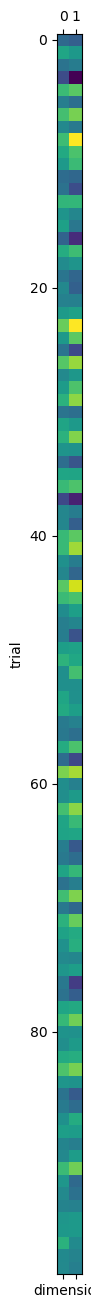

In [6]:
# Add your code
plt.matshow(X)
plt.xlabel('dimension')
plt.ylabel('trial')

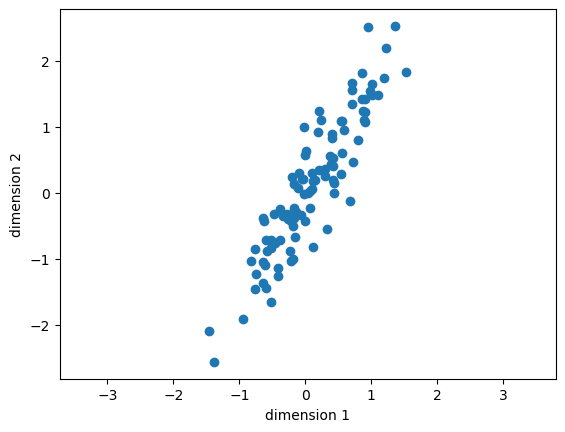

In [7]:
plt.scatter(X[:,0], X[:,1])
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.axis('equal')
plt.show()

#### TODO: 

What would be a new axis that will make the data vary the most when the data are projected? Which of the two dimensions should we weigh more heavily?

> To project the data onto a new axis, we should weigh the x and y dimensions equally. The data varies most along the line y = x, but based on how the np array was called, I think it's most so along the line y = 1.2x + 0.2. Therefore, we should weigh the x-axis more heavily since it has a steeper slope.

Now we will run a PCA to find that axis (first principal component) and another axis that is perpendicular to the 1st PC.

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

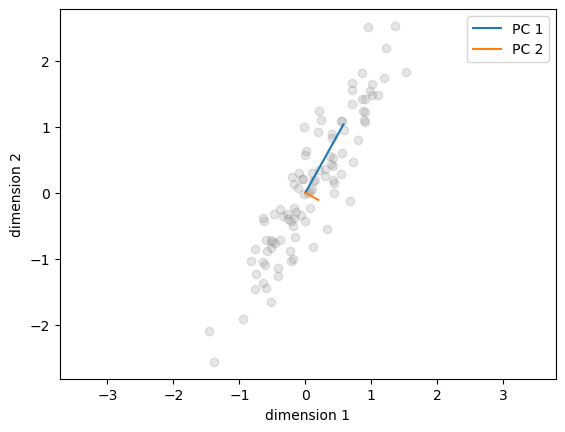

In [9]:
plt.scatter(X[:,0], X[:,1], c='gray', alpha=0.2)
# draw Principal Components
for i in range(2):
    vec = pca.components_[i, :] * (np.sqrt(pca.explained_variance_[i]))
    plt.plot([0, vec[0]], [0, vec[1]], label=f'PC {i+1}')
    
plt.legend()
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.axis('equal') # keep the axis ratio equal 
plt.show()

Let's rotate the axis so that your principal components are the new axes. 

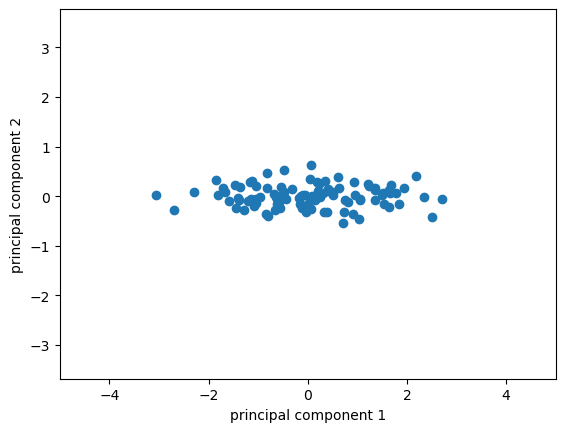

In [10]:
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.axis('equal')
plt.xlim([-5,5])
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

In [11]:
def plot_transformation(x, y):
    """
    Plot data points in the first two principal components 
    
    Args:
    x (m x n array): original data
    y (m x n array): transformed data in the reduced dimensions
    """

    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    
    plt.axhline(-1, color='black',linewidth=0.5, linestyle=':')
    plt.axvline(-1, color='black',linewidth=0.5, linestyle=':')
    plt.axhline(1, color='black',linewidth=0.5, linestyle=':')
    plt.axvline(1, color='black',linewidth=0.5, linestyle=':')
    
    plt.scatter(x[:, 0], x[:, 1], marker = 'x', c='gray', alpha=0.1, label='original')
    
    # draw m lines from each original point to its transformed point
    for i in range(m):
        plt.plot([x[i, 0], y[i, 0]], [x[i, 1], y[i, 1]], color='gray', alpha=0.1)  # Line from x to y
      
    plt.scatter(y[:, 0], y[:, 1], c='black', alpha=0.2, label='transformed')
    
    plt.title('original vs transformed data points')
    plt.xlabel('principal component 1')
    plt.ylabel('principal component 2')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

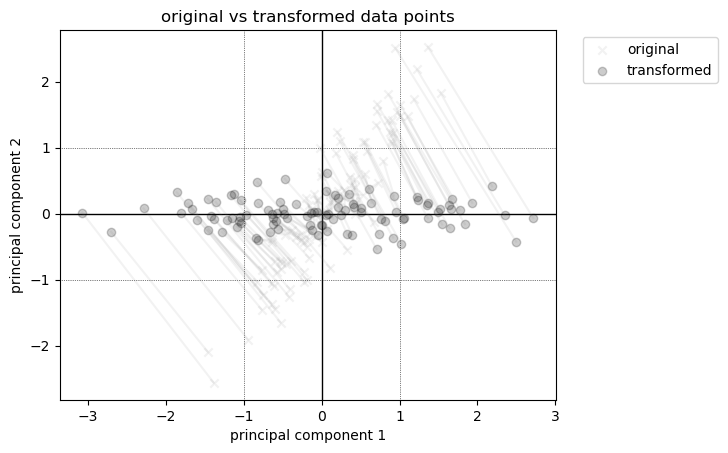

In [12]:
plot_transformation(X, X_pca)

## Exercise: Reducing dimensionality of motor cortext activity during arm reaching task

In this exercise, we will use PCA to visualize the activity of a large population of neurons recorded in macaque motor cortex during a arm reaching task (outward movement from the center). The data were collected in Nicho Hatsopolous's lab at University of Chicago, and are in the file `ReachData.mat`.

The matrix `R` contains the firing rate of each of 143 neurons for a total of 158 trials. The vector `direction` specifies the reach direction for each of the 158 trials. Direction 1 corresponds to a rightward reach (0 degrees), direction 2 to 45 degrees, direction 3 to 90 degrees (straight up), etc, with direction 8 corresponding to 315 degrees. Think about the orientation of the matrix R before you proceed.

In [13]:
# load data
data = loadmat('/home/dist/lab6_PCA/ReachData.mat')

# extract
# extract matrix R and vector direction from the .mat file
R = data['R']
direction = (data['direction'].flatten().astype(np.int32) - 1)* 45 # 45 degree x 8

# check shape for R
print(f"R shape: {R.shape}") # initially, rows represent # of neurons, columns are # of trials

# check directions
print(f"directions: {direction}")


R shape: (143, 158)
directions: [ 90 180 180  45 225  90 270 135  90 135  45   0 315 180 135  45 135 270
 180  45 180   0 180 135  90 225 315   0   0  90 180 270 135   0  90 270
 315 180 180  45  90 270   0 315 180  90 270 135  45 180 315 315 180 270
 270 135  45 225 135 225 225 180 135  90 180 225 270 315  90 135   0 315
 180  90  90   0 180 225 225  90 270  90   0 225 315 270  90 135   0 180
 270 225  90 315 270 225  90 225 315 225 135 225  90  45 225   0 270 225
 315 225 225 270 135 135 135 270  45  45 315 135  90 315   0 270 270 270
 225 135 270 180 180 315 225 180 270  90 225 180 225  90  90 270 135 135
 180 225 315   0 225  45 180 270 180  45 180 270   0 315]


#### TODO: 

Transpose data matrix R such that the rows represent number of trials and columns represent the number of neurons. Inspect the data in the transposed matrix `R` by plotting the matrix as an image using `plt.matshow`. Label axes as "neuron" and "trial".

Text(0, 0.5, 'trial')

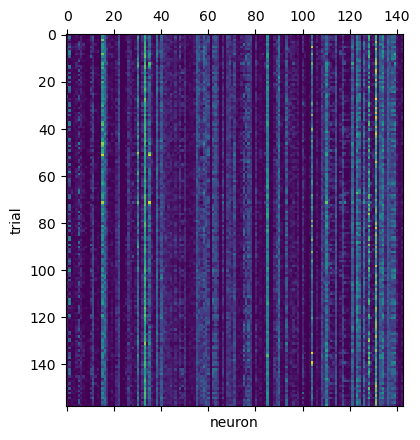

In [14]:
# Add your code
R = R.T # transpose R
plt.matshow(R)
plt.xlabel('neuron')
plt.ylabel('trial')

#### TODO: 

Get the data matrix R's size as variables `m` and `n`. `m` should correspond to the number of trials, and `n` should correspond to the number of neurons recorded.

In [16]:
# Add your code
m, n = np.shape(R)[0], np.shape(R)[1] # assign m and n
print(f"number of trials: {m}, number of neurons: {n}") # sanity check: looks good!

number of trials: 158, number of neurons: 143


When plotting, we will use different colors to mark each direction.

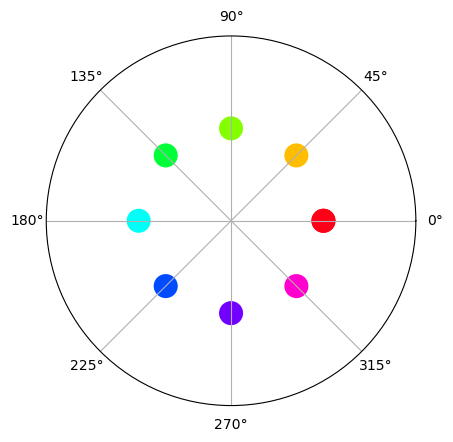

In [15]:
# set color scheme
cols = plt.cm.hsv(np.linspace(0, 1, len(np.unique(direction))+1))

xval = np.linspace(0, 2*np.pi, 9)
yval = np.ones_like(xval)

colormap = plt.get_cmap('hsv')

ax = plt.subplot(1, 1, 1, polar=True)
ax.scatter(xval, yval, c=cols, s=300, linewidths=0)
ax.set_yticks([])
plt.show()

Now, let's plot the data. There are 143 neurons, but we will start by plotting first two neurons' behaviors.

In [17]:
def plot_2d(mat, label, dim1, dim2):    
    # create a figure
    plt.figure()
    
    # loop over conditions (directions)
    for i, c in enumerate(np.unique(label)):
      plt.scatter(mat[label == c, dim1], mat[label == c, dim2],
                  color = cols[i], label = f'{c} degrees', # color to label condition
                  alpha = 0.6)
    
    # legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Text(0, 0.5, 'neuron 2 firing rate (Hz)')

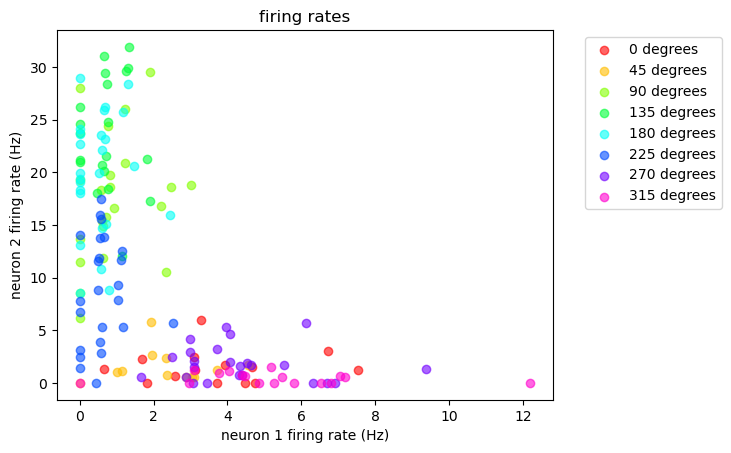

In [18]:
plot_2d(mat=R, label=direction, dim1=0, dim2=1)
plt.title("firing rates")
plt.xlabel(f"neuron {1} firing rate (Hz)")
plt.ylabel(f"neuron {2} firing rate (Hz)")

#### TODO:

Based on the figure above, what does neuron 1 seem to be coding for?

> Neuron 1 seems to be coding for the right side of the above circle (0 degrees, 45 degrees, 270 degrees, and 315 degrees).

What about neuron 2?

> Neuron 2 seems to be coding for the left side of the above circle (225, 180, 135, and 90 degrees). 

#### TODO:

Plot neuron 18 annd neuron 48.

Text(0, 0.5, 'neuron 48 firing rate (Hz)')

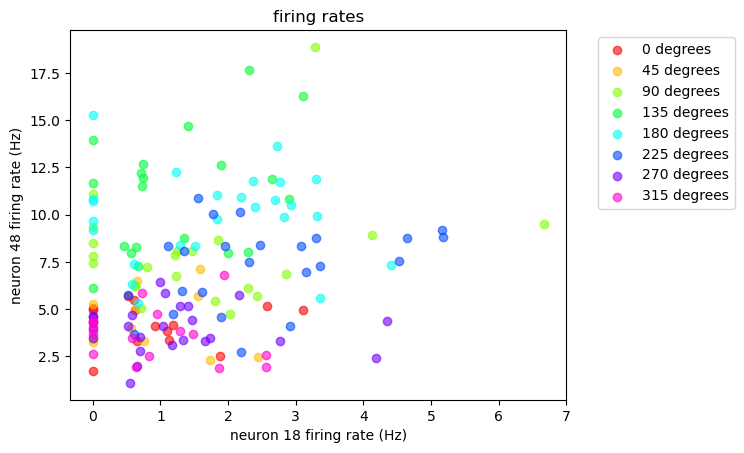

In [19]:
# Add your code
plot_2d(mat=R, label=direction, dim1=18, dim2=48)
plt.title("firing rates")
plt.xlabel(f"neuron {18} firing rate (Hz)")
plt.ylabel(f"neuron {48} firing rate (Hz)")

#### TODO:

Based on the figure above, what does neuron 18 and 48 seem to be coding for?

> It seems like neuron 48 fires regardless of whether neuron 18 does: neuron 48 fires at higher rates for 90 degrees, 180 degrees, or 225 degrees than 315, 45 or 0 degrees. Neuron 18 doesn't seem to fire unless neuron 48 is firing, which is when it fires most for 225 and 270 degrees. Overall, it seems like neuron 48 is coding for left side of the color figure, while neuron 16 is coding for specifically the bottom left side of the color figure.

#### TODO:

Now, run a principal component analysis on `R`. You should find two new axes (components) and **plot** the data on the new plane (PC1 and PC2) using the `plot_2d` function. Label axes properly.

(-40.0, 40.0)

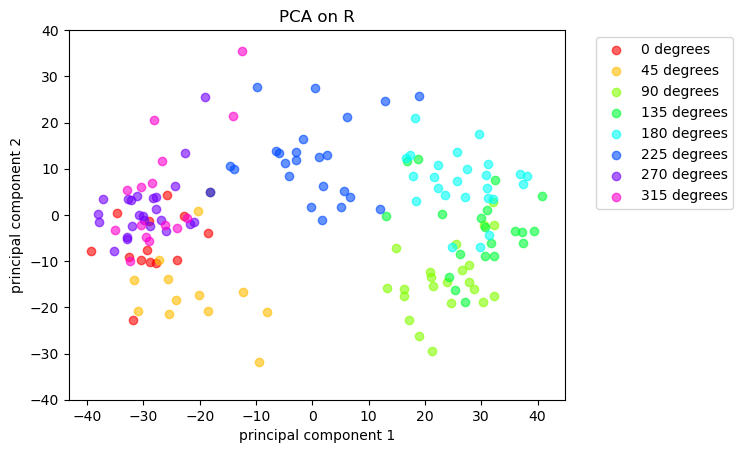

In [21]:
# run the pca
pca = PCA(n_components=2)
R_pca = pca.fit_transform(R)

# use plot 2d function to plot principal components
plot_2d(mat=R_pca, label=direction, dim1=0, dim2=1)
plt.title("PCA on R")
plt.xlabel(f"principal component {1}")
plt.ylabel(f"principal component {2}")
plt.ylim([-40, 40])

#### TODO:

What do you think each of the principal components are representing?

> I think that the first principal component prefers left & right sides of the wheel (suppression = left side, activation = right side), while the second principal component is representing the top and bottom orientations (suppression = 45 or 90 degrees, activation = 315 or 225 degrees, baseline = 270, 0, 180).
> I think each principal component represents the left/right strip of the motor cortex of monkeys. Recalling that each strip controls the muscles on the opposite side of the body, we can see that the left/right sides of the angle wheel are encoded on the opposite side of the above plot.

Summarize your finding in the monkey motor neurons. What are the benefits of reducing dimensions of the data?

> Reducing the number of dimensions in the data is helpful as it allows us to see through the noise of individual neurons and to the larger structure managing movement, the motor cortex. The two principal components relate to the two strips of the motor cortrex that control the opposite side body. PCA was als

<div class="alert alert-block alert-info">
    <b>Grade:</b> 5/5 <br>
</div>